In [24]:
import tensorflow as tf

In [25]:
%pip install imageio  # bridge between files and numpy arrys
%pip install git+https://github.com/tensorflow/docs



  Cloning https://github.com/tensorflow/docs to c:\users\t50660\appdata\local\temp\pip-req-build-7iqbe0qp
  Resolved https://github.com/tensorflow/docs to commit e21d085d5ed82504ffcec11aa82ebc78f1f2302e
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs 'C:\Users\T50660\AppData\Local\Temp\pip-req-build-7iqbe0qp'


In [26]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [27]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data() #using MNIST datasset

In [28]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')# convert the img to 28,28,1
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [29]:
BUFFER_SIZE = 60000 #used in shuffling dataset
BATCH_SIZE = 256 # how many samples are processed in one forward/backward pass

In [30]:
# Batch and shuffle the data 
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [31]:
# creating generator
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU()) # this will perform better adviced in paper 

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1) #original img size 

    return model

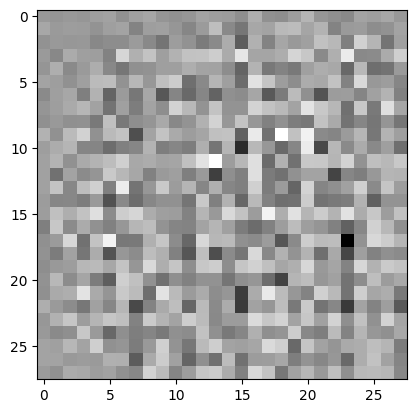

In [32]:
generator = make_generator_model() # creating instance of the generator model

noise = tf.random.normal([1, 100]) # add noise vector (batchsize=1, latent space=100)
generated_image = generator(noise, training=False) # pass noise through generator to create a fake image

plt.imshow(generated_image[0, :, :, 0], cmap='gray') # Display

In [33]:
#building discriminator
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))#avoid overfitting  

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [34]:
discriminator = make_discriminator_model() # Create an instance of discriminator 
decision = discriminator(generated_image) # test generated image
print (decision)

tf.Tensor([[-0.00087933]], shape=(1, 1), dtype=float32)


In [35]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) 

In [36]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) # loss for classifying real img as real(Lable = 1)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) # Loss for classifying fack img as fake(lable = 0)
    total_loss = real_loss + fake_loss 
    return total_loss

In [37]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output) # generator wants discriminator to classify fake img as real

In [38]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4) # Optimizer for updating generator's weights
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4) # Optimizer for updating discriminator's weights

In [39]:
#checkpoints you dont lose progress while training your GAN 
checkpoint_dir = './training_checkpoints' # Directory
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt") # prefix for checkpoint
# create a checkpoint object to save/restore model and optimizers
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [41]:
EPOCHS = 10
noise_dim = 100
num_examples_to_generate = 16 # no on img to generate for monitoring progress

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [42]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function # complie the fuction for faster execution eith tensorflow graph optimization
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim]) # generate random noise input for the generator 
    
    #Record operations for automatic differentiation
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True) # Generator creates fake images from noise

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)  # Calculate generator loss
      disc_loss = discriminator_loss(real_output, fake_output) # Calculate discriminator loss
    # Compute gradients for generator and discriminator
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # Apply gradients to update generator weights
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    # Apply gradients to update discriminator weights
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [43]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    # iterate over teh dataset and train in batches
    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)  # clear previous output for cleaner visualization
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [44]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  # Create a 4x4 grid for displaying 16 generated images
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')  # Scale pixel values back from [-1, 1] to [0, 255] and display in grayscale
      plt.axis('off')
  # Save the generated image grid for this epoch
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

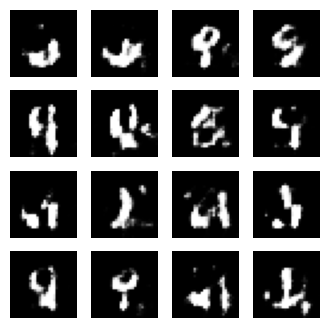

In [45]:
train(train_dataset, EPOCHS)